In [38]:
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from itertools import product
import matplotlib.pyplot as plt

In [39]:
def mean_euclidean_error(vectors1, vectors2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - vectors1: NumPy array of shape (N, 3) representing the first set of 3D vectors
    - vectors2: NumPy array of shape (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the input arrays have the correct shape
    if vectors1.shape != vectors2.shape or vectors1.shape[1] != 3:
        raise ValueError("Input arrays must be of shape (N, 3)")

    # Compute Euclidean distance
    euclidean_distance = np.linalg.norm(vectors1 - vectors2, axis=1)

    # Calculate the mean Euclidean error
    mean_error = np.mean(euclidean_distance)

    return mean_error

In [40]:
class MultiSVM:
    """
    A wrapper class for multiple Support Vector Regressors (SVRs) with shared hyperparameters.

    Parameters:
    - kernel (str, optional): Specifies the kernel type ('linear', 'poly', 'rbf', 'sigmoid', etc.).
    - C (float, optional): Regularization parameter. Controls the trade-off between smooth decision function and fitting the training data.
    - epsilon (float, optional): Width of the epsilon-insensitive tube. Ignored errors within this range during training.
    - degree (int, optional): Degree of the polynomial kernel. Only applicable for 'poly' kernel.

    Attributes:
    - svr0, svr1, svr2: Support Vector Regressors for each target dimension.

    Methods:
    - fit(X, y): Fit each SVR on its respective target dimension.
    - predict(X): Make predictions using each SVR and return a stacked array of predictions.
    """

    def __init__(self, kernel='rbf', C=1.0, epsilon=0.1, degree=3):
        # Create three support vector regressors with the specified kernel, regularization parameter, and epsilon
        self.svr0 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree)
        self.svr1 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree)
        self.svr2 = SVR(kernel=kernel, C=C, epsilon=epsilon, degree=degree)

    def fit(self, X, y):
        # Fit each SVR on its respective data
        self.svr0.fit(X, y[:,0])
        self.svr1.fit(X, y[:,1])
        self.svr2.fit(X, y[:,2])

    def predict(self, X):
        # Make predictions using each SVR
        pred = np.column_stack((self.svr0.predict(X),self.svr1.predict(X),self.svr2.predict(X)))
        return pred

In [41]:
def perform_grid_search_kfold(kernels, Cs, epsilons, degrees, k_folds, x, y, return_sequence=False):
    """
    Perform grid search with k-fold cross-validation for Support Vector Regression hyperparameters.

    Parameters:
    - kernels (list): List of kernel types to search.
    - Cs (list): List of regularization parameters to search.
    - epsilons (list): List of epsilon values to search.
    - degrees (list): List of degrees for polynomial kernels.
    - k_folds (int): Number of folds for cross-validation.
    - x (numpy.ndarray): Input data.
    - y (numpy.ndarray): Target data.
    - return_sequence (bool, optional): Whether to return the mean Euclidean error sequence (default: False).

    Returns:
    - list or tuple: Best hyperparameters or tuple with best hyperparameters
        and sequences of mean Euclidean errors.

    The function performs grid search with k-fold cross-validation for
    Support Vector Regression hyperparameters and returns the best hyperparameters.
    """

    mee_sequence = []
    mee_sd_sequence = []
    best_mee = float('inf')
    best_mee_std = 0
    best_hyperparams = []
    counter = 0
    num_combinations = sum(1 for _ in product(kernels, Cs,epsilons, degrees))
    print('total number of grid search combinations explored:',num_combinations)
    for kernel, C,epsilon,  degree in product(kernels, Cs,epsilons, degrees):
        counter += 1
        print(f'{counter}/{num_combinations} Hyperparams:',kernel, C, epsilon, degree)

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        val_mees = []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]

            model = MultiSVM(kernel, C, epsilon, degree)
            model.fit(X_train,y_train)
            val_mees.append(mean_euclidean_error(model.predict(X_val),y_val))

        print(f'Final Results: kernel={kernel}; C={C}; epsilon={epsilon}; deg = {degree} --> '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        mee_sequence.append(np.mean(val_mees))
        mee_sd_sequence.append(np.std(val_mees))
        if np.mean(val_mees) < best_mee:
            best_mee = np.mean(val_mees)
            best_mee_std = np.std(val_mees)
            best_hyperparams = [kernel, C, epsilon, degree]

    print(f'Best Hp: {best_hyperparams} with MEE = {best_mee} +- {best_mee_std}')
    if return_sequence:
        return best_hyperparams, np.array(mee_sequence), np.array(mee_sd_sequence)
    else:
        return best_hyperparams

In [42]:
def plot_mean_std(cs,mee,std):
    """
    Plot mean Euclidean error (MEE) along with standard deviation.

    Parameters:
    - cs (array-like): Values of the hyperparameter C.
    - mee (array-like): Mean Euclidean error values.
    - std (array-like): Standard deviation of Euclidean error values.

    The function plots the mean Euclidean error (MEE) along with its
    standard deviation based on the values of the hyperparameter C.
    """

    plt.figure(figsize=(9, 8))
    plt.plot(cs,mee, label='MEE $\pm$ std. (results of k-fold cross validation)', color = 'green', linewidth=1)
    plt.fill_between(cs,mee-std, mee+std, color='green', alpha=0.3)

    plt.xlabel('C values')
    plt.ylabel('MEE')
    plt.legend()

    plt.legend()
    plt.show()


# Load the dataset

In [43]:
from sklearn.model_selection import train_test_split

# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Coarse Grid Searches (to find best kernel)
we perform two grid searches. One with the rbf kernel, and one with polinomial kernel, and in this latter case we include the degree of the polinomial as hyperparameter. We compare the results of k-fold cross validation to choose the kernel most suitable for our problem.

In [45]:
'''
#first coarse grid search
kernels = ['rbf']
Cs = [0.01,0.1,1,10,100,1000]
epsilons = [0.01,0.1,1,10]
degrees=[0] #only relevant for poly kernel
#Best Hp: ['rbf', 1000, 0.1] with MEE = 0.6396615599226871 +- 0.04980493197143183
'''

kernels = ['poly']
Cs = [0.01,0.1,1,10,100,1000]
degrees = np.arange(3,30,1)
epsilons = [0.01,0.1,1,10]
#Best Hp: ['poly', 1000, 0.01, 5] with MEE = 0.8183841594881777 +- 0.12792331527745304

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

total number of grid search combinations explored: 24
1/24 Hyperparams: rbf 0.01 0.01 0
Final Results: kernel=rbf; C=0.01; epsilon=0.01; deg = 0 --> val_mee = 37.9 +- 1.636
2/24 Hyperparams: rbf 0.01 0.1 0
Final Results: kernel=rbf; C=0.01; epsilon=0.1; deg = 0 --> val_mee = 37.9 +- 1.631
3/24 Hyperparams: rbf 0.01 1 0
Final Results: kernel=rbf; C=0.01; epsilon=1; deg = 0 --> val_mee = 37.9 +- 1.625
4/24 Hyperparams: rbf 0.01 10 0
Final Results: kernel=rbf; C=0.01; epsilon=10; deg = 0 --> val_mee = 37.35 +- 1.392
5/24 Hyperparams: rbf 0.1 0.01 0
Final Results: kernel=rbf; C=0.1; epsilon=0.01; deg = 0 --> val_mee = 30.47 +- 1.442
6/24 Hyperparams: rbf 0.1 0.1 0
Final Results: kernel=rbf; C=0.1; epsilon=0.1; deg = 0 --> val_mee = 30.47 +- 1.445
7/24 Hyperparams: rbf 0.1 1 0
Final Results: kernel=rbf; C=0.1; epsilon=1; deg = 0 --> val_mee = 30.49 +- 1.497
8/24 Hyperparams: rbf 0.1 10 0
Final Results: kernel=rbf; C=0.1; epsilon=10; deg = 0 --> val_mee = 31.32 +- 1.232
9/24 Hyperparams: rbf

# Finer Grid Search
the best kernel is rbf, now let's study the other hyperparameters more in detail

In [ ]:
'''
#finer grid search
kernels = ['rbf']
Cs = [1000,2000,3000,4000,5000]
epsilons = [0.1,0.2,0.3,0.4,0.5]
# Best Hp: ['rbf', 3000, 0.1] with MEE = 0.6172759223965806 +- 0.06576969897515686
'''

'''
#best hp untill now:
kernels = ['rbf']
Cs = [3000]
epsilons = [0.1]
'''

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

### Study the effect of the parameter C.
Keeping $\varepsilon$ fixed, we want to study the effect of C on the validation error. 
- Low C ---> many TR errors are allowed (risk of underfitting)
- High C ---> less TR errors allowed (risk of overfitting)

In [49]:
kernels = ['rbf']
Cs = np.arange(200, 10000, 200)
epsilons = [0.1]
#Best Hp: ['rbf', 2800, 0.1] with MEE = 0.6164267250857903 +- 0.0641407687516038

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 49
1/49 Hyperparams: rbf 200 0.1 0
Final Results: kernel=rbf; C=200; epsilon=0.1; deg = 0 --> val_mee = 0.7814 +- 0.04356
2/49 Hyperparams: rbf 400 0.1 0
Final Results: kernel=rbf; C=400; epsilon=0.1; deg = 0 --> val_mee = 0.6983 +- 0.04279
3/49 Hyperparams: rbf 600 0.1 0


KeyboardInterrupt: 

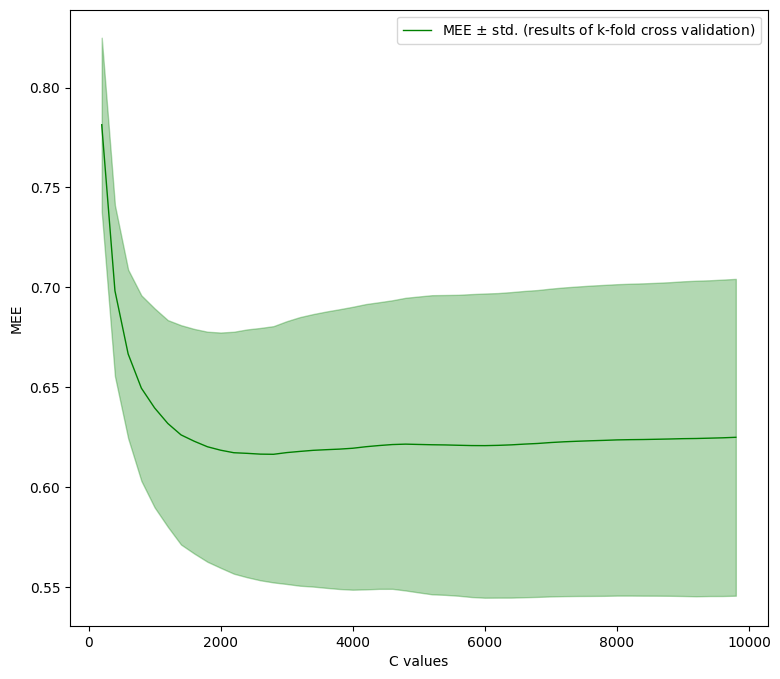

In [ ]:
#plot the values of mees changing the values of C
plot_mean_std(Cs,mees,mees_sd)

# Train the final model on all the training data
Finally, we train our best model on all the training data.
We test its performances on our internal test set.

In [50]:
best_hyperparams = ['rbf', 2800, 0.1]
model = MultiSVM(*best_hyperparams)
model.fit(X_train,y_train)
print('Test MEE:',mean_euclidean_error(model.predict(X_test),y_test))

Test MEE: 0.5072068974377768
